# Analyzing Olist E-commerce Operations in the Top Five States during Peak Time

**Background**: What are the Top 5 States / Peak Time? Why should we seriously focus? Are there any problems related to Orders and Delivery in those areas in Peak Time?

Olist recently experienced a Peak phase, when its order volume and revenue substantially increased in two of the previous three months. To get ready for the next cycle, the performance of Peak Time would be re-evaluated in the five states with the liveliest e-commerce activity on Olist.

This analysis will provide an overview of E-commerce performance in Peak Time, as well as help managers be aware of deep-down late delivery problems in some potential business areas.

**1. Target Audience**: Business/Logistics Analyst Manager of Olist
   
**2. Metric**: 
- **Number of Orders (Order Quantity, Order Q)**
- **% Change of Orders** (*of a month*) = Order Q (*this month) -* Order Q *(previous month)* / Order Q (*previous month*) *100%
- **Ratio of Late Orders** = Late Orders / Total Orders (*same criteria*) *100%

**3. Flow of analysis**:
- Find out what and why we should focus on **Top 5 States**, **Peak Time.**
- Analyze performance in the Top 5 States, in Peak Time, including:
    - Analysis by **Category**
    - Analysis by **Location**
    - Particular **delivery problems** which should be considered

<img src="https://i.imgur.com/qjfOHdm.png" width="800" height="600">

# Python Libraries and Datasets Input

In [9]:
#Input Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
#Input csv
location = pd.read_csv('olist_geolocation_dataset.csv')
seller = pd.read_csv('olist_sellers_dataset.csv')
customer = pd.read_csv('olist_customers_dataset.csv')
item = pd.read_csv('olist_order_items_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')
product = pd.read_csv('olist_products_dataset.csv')
payment = pd.read_csv('olist_order_payments_dataset.csv')
review = pd.read_csv('olist_order_reviews_dataset.csv')
category = pd.read_csv('product_category_name_translation.csv')

In [11]:
#Information of shapes of datasets:
print (location.shape)
print (seller.shape)
print (customer.shape)
print (item.shape)
print (order.shape)
print (product.shape)
print (payment.shape)
print (review.shape)
print (category.shape)

(1000163, 5)
(3095, 4)
(99441, 5)
(112650, 7)
(99441, 8)
(32951, 9)
(103886, 5)
(99224, 7)
(71, 2)


In [12]:
#Set columns' names
location.columns = ['zipcode','lat','long','city','state']
seller.columns = ['s_id','zipcode','s_city','s_state']
customer.columns = ['c_id','c_uid','zipcode','c_city','c_state']
item.columns = ['o_id','item','p_id','s_id','limit','price','freight']
order.columns = ['o_id','c_id','status','purchase','approved','carrier','deliver_act','deliver_est']
product.columns = ['p_id','category_ptg','name_len','descrip_len','photo_qty','weight','length','height','width']
payment.columns = ['o_id','seq','type','installments','value']
review.columns = ['r_id','o_id','score','title','message','creation','answer']
category.columns = ['category_ptg','category']

#Casttype to timeline
item['limit'] = pd.to_datetime(item['limit'])
order['purchase'] = pd.to_datetime(order['purchase'])
order['approved'] = pd.to_datetime(order['approved'])
order['carrier'] = pd.to_datetime(order['carrier'])
order['deliver_act'] = pd.to_datetime(order['deliver_act'])
order['deliver_est'] = pd.to_datetime(order['deliver_est'])

# Merging tables

The idea of merging of merging table in the beginning is to unite all necessary information (`orders` - `products` - `sellers` - `customers` - `payments`) into one table for further analysis. The central and most important tables when analysing orders are `order` and `item` datasets. 

In [15]:
df_order = pd.merge(order, item, how='outer', on='o_id') #To get all order id of 'order' and 'item' tables. NULLs order_id are excluded later.
df_order = pd.merge(df_order, product, how='left', on='p_id')
df_order = pd.merge(df_order, category, how='left', on='category_ptg') 
df_order = pd.merge(df_order, seller, how='left', on='s_id')
df_order = pd.merge(df_order, customer, how='left', on='c_id')
df_order = pd.merge(df_order, payment, how='left', on='o_id')
#Left mergings are used to keep all order_id information unchanged or to be excluded unexpectedly

In [16]:
df_order.head()

,o_id,c_id,status,purchase,approved,carrier,deliver_act,deliver_est,item,p_id,...,s_city,s_state,c_uid,zipcode_y,c_city,c_state,seq,type,installments,value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,belo horizonte,SP,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,guariba,SP,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


In [17]:
df_order.shape

(118434, 34)

In [18]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   o_id          118434 non-null  object        
 1   c_id          118434 non-null  object        
 2   status        118434 non-null  object        
 3   purchase      118434 non-null  datetime64[ns]
 4   approved      118258 non-null  datetime64[ns]
 5   carrier       116360 non-null  datetime64[ns]
 6   deliver_act   115037 non-null  datetime64[ns]
 7   deliver_est   118434 non-null  datetime64[ns]
 8   item          117604 non-null  float64       
 9   p_id          117604 non-null  object        
 10  s_id          117604 non-null  object        
 11  limit         117604 non-null  datetime64[ns]
 12  price         117604 non-null  float64       
 13  freight       117604 non-null  float64       
 14  category_ptg  115906 non-null  object        
 15  name_len      115

In [19]:
df_order.describe()

,item,price,freight,name_len,descrip_len,photo_qty,weight,length,height,width,zipcode_x,zipcode_y,seq,installments,value
count,117604.000000,117604.000000,117604.000000,115906.000000,115906.000000,115906.000000,117584.000000,117584.000000,117584.00000,117584.000000,117604.000000,118434.000000,118431.000000,118431.000000,118431.000000
mean,1.195920,120.822849,20.045551,48.767208,786.957302,2.207849,2114.281067,30.256872,16.63029,23.068394,24442.886483,35034.264392,1.094207,2.937398,172.849395
std,0.697721,184.477367,15.861351,10.035162,653.029009,1.719519,3788.754048,16.190874,13.45878,11.748372,27573.802989,29819.290218,0.728290,2.774164,268.259831
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.00000,6.000000,1001.000000,1003.000000,1.000000,0.000000,0.000000
25%,1.000000,39.900000,13.080000,42.000000,347.000000,1.000000,300.000000,18.000000,8.00000,15.000000,6429.000000,11310.000000,1.000000,1.000000,60.860000
50%,1.000000,74.900000,16.290000,52.000000,601.000000,1.000000,700.000000,25.000000,13.00000,20.000000,13660.000000,24240.000000,1.000000,2.000000,108.200000
75%,1.000000,134.900000,21.190000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.00000,30.000000,28035.000000,58464.500000,1.000000,4.000000,189.245000
max,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.00000,118.000000,99730.000000,99990.000000,29.000000,24.000000,13664.080000


# Data Wrangling

The overall process of this step is described by following points:
- Handling duplicated data.
- Missing data/ NULLs Values.
- Analyzing the `status` column.
- Narrowing timeline.
- Drop unnecessary columns, create new columns, correct datatypes.

## 2.1. Duplicated data

In [23]:
df_order.duplicated().sum()

0

In [24]:
print (order['o_id'].nunique())
print (item['o_id'].nunique())

99441
98666


Checking duplicates in each columns is unnecessary because duplicates in these columns are acceptable. 

## 2.2. NULLs values

In [27]:
df_order.isna().sum()

o_id               0
c_id               0
status             0
purchase           0
approved         176
carrier         2074
deliver_act     3397
deliver_est        0
item             830
p_id             830
s_id             830
limit            830
price            830
freight          830
category_ptg    2528
name_len        2528
descrip_len     2528
photo_qty       2528
weight           850
length           850
height           850
width            850
category        2553
zipcode_x        830
s_city           830
s_state          830
c_uid              0
zipcode_y          0
c_city             0
c_state            0
seq                3
type               3
installments       3
value              3
dtype: int64

- 830 NULL values in `item`, `p_id`, `s_id`, `limit`, `price`, `freight` is from outer merging `order` and `item` tables, which are orders having status and customer information but not having its item information. It doesn't account for a large scale in the amount of `df_order` information so it can be excluded.
- Other NULL values of `product` and `payment` information is from original table, which can also be excluded as they don't account for a significant scale in the whole dataset.

In [29]:
df_order.dropna(subset=['p_id'], inplace=True)
df_order.dropna(subset=['category','weight','seq'], inplace=True)
df_order.isna().sum()

o_id               0
c_id               0
status             0
purchase           0
approved          14
carrier         1205
deliver_act     2495
deliver_est        0
item               0
p_id               0
s_id               0
limit              0
price              0
freight            0
category_ptg       0
name_len           0
descrip_len        0
photo_qty          0
weight             0
length             0
height             0
width              0
category           0
zipcode_x          0
s_city             0
s_state            0
c_uid              0
zipcode_y          0
c_city             0
c_state            0
seq                0
type               0
installments       0
value              0
dtype: int64

## 2.3. Analyzing the `status` columns

In [31]:
df_order['status'].value_counts()

delivered      113383
shipped          1214
canceled          549
processing        362
invoiced          359
unavailable         7
approved            3
Name: status, dtype: int64

*Features of all unique status:*
    
*1. **created**: orders have only been uploaded, **not yet approved**.*
    
*2. **approved**: already been **approved** - **not yet** on **carrier** and **deliver_act**.*
    
*3. **processing**: processing the invoice - already been **approved**, **not yet** on **carrier** and **deliver_act**.*
    
*4. **invoiced**: already been **invoiced** - **not yet** on **carrier** and **deliver_act**.*
    
*5. **shipped**: being shipped, already been on **carrier** (handover to shipping unit), **no deliver_act** yet.*
    
*6. **delivered**: information is fully uploaded (except for some missing **delivered_act** information).*
    
*7. **canceled**: some canceled approved, some canceled carrier. 6 orders with complete information (including **deliver_act**), 618 **`NULLs` deliver_act**.*  

*8. **unavailable**: **approved** but not available - **carrier** and **deliver_act** are **`NULLs`***.

The proportion of **delivered** order dominated other unique status types(98%). For further analysis which sufficient information, orders with **delivered** status are kept. 

In [34]:
df_order = df_order[df_order['status']=='delivered'].dropna(subset=['carrier','deliver_act'])
#After filtering into data with only 'delivered' status, there are still 8 orders without actual delivery date.

## 2.4. Narrowing analyzed timeline

There are a lot of timeline columns in the `df_order` dataset. In the real business activies, at the moment when a customer purchases, revenue and other business indexes are validly recorded. **The `purchase` column, therefore, is taken as a timeline mark** for further analysis. 

In [37]:
#Extract month, year, period to Month for 'purchase' column
df_order['year'] = df_order['purchase'].dt.year
df_order['month'] = df_order['purchase'].dt.month
df_order['year_month'] = df_order['purchase'].dt.to_period('M')

In [38]:
df_order.groupby('year_month')['o_id'].count().reset_index()

,year_month,o_id
0,2016-10,328
1,2016-12,1
2,2017-01,950
3,2017-02,1905
4,2017-03,3014
5,2017-04,2628
6,2017-05,4161
7,2017-06,3627
8,2017-07,4655
9,2017-08,4974


The data in 2016 is abnormally low which might come from insufficient records. Therefore, the data will be narrowed down from **Jan 2017 to Aug 2018** for better timeline analysis.

In [40]:
df_order = df_order[df_order['year']>=2017]

## 2.5. Drop unnecessary columns, create new columns, correct datatypes

In [42]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113045 entries, 0 to 118433
Data columns (total 37 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   o_id          113045 non-null  object        
 1   c_id          113045 non-null  object        
 2   status        113045 non-null  object        
 3   purchase      113045 non-null  datetime64[ns]
 4   approved      113031 non-null  datetime64[ns]
 5   carrier       113045 non-null  datetime64[ns]
 6   deliver_act   113045 non-null  datetime64[ns]
 7   deliver_est   113045 non-null  datetime64[ns]
 8   item          113045 non-null  float64       
 9   p_id          113045 non-null  object        
 10  s_id          113045 non-null  object        
 11  limit         113045 non-null  datetime64[ns]
 12  price         113045 non-null  float64       
 13  freight       113045 non-null  float64       
 14  category_ptg  113045 non-null  object        
 15  name_len      113

**Revenue** of an order is calculated by adding the `price` and `freight` of that order.

In [44]:
#Calculate Revenue for Order in the dataset
df_order['revenue'] = df_order['price'] + df_order['freight']

In the dataset, `category_ptg` and `zipcode` are unnecessary columns, which can be **dropped**.

In [46]:
#Drop unnecessary columns
df_order.drop(columns=['category_ptg','zipcode_x','zipcode_y'],inplace=True)

There are 3 columns: `item`, `seq`, `installments`, which should be in **integer** instead of **float**. The `purchase_year_month` column should be in **string** for easier plots.

In [48]:
#Adjust types of some data columns
df_order['item'] = df_order['item'].astype('int')
df_order['seq'] = df_order['seq'].astype('int')
df_order['installments'] = df_order['seq'].astype('int')
df_order['year_month'] = df_order['year_month'].astype('str')

In [49]:
#Calculate the size of an order
df_order['size'] = df_order['length']*df_order['height']*df_order['width']

#Calculate relevant figures related to delivery days 
df_order['est_dlv'] = (df_order['deliver_est'] - df_order['approved']).dt.days 
df_order['act_dlv'] = (df_order['deliver_act'] - df_order['approved']).dt.days
df_order['act_est'] = (df_order['deliver_act'] - df_order['deliver_est']).dt.days
df_order['dlv_pur'] = (df_order['deliver_act'] - df_order['purchase']).dt.days

#Calculate the number of days for each period in the delivery process
df_order['app_pur'] = (df_order['approved'] - df_order['purchase']).dt.days
df_order['cr_app'] = (df_order['carrier'] - df_order['approved']).dt.days
df_order['dlv_cr'] = (df_order['deliver_act'] - df_order['carrier']).dt.days

In [50]:
#Define an order is made and delivered in the same state or not
def same_state(row):
    if row['s_state'] == row['c_state']:
        return 'same'
    else:
        return 'not'

df_order['same_state'] = df_order.apply(same_state,axis=1)

In [51]:
#Define a late order
def late_dlv(row):
    if row['deliver_act']<= row['deliver_est']:
        return 'on_time'
    else: 
        return 'late'
df_order['late_dlv'] = df_order.apply(late_dlv,axis=1)

In [52]:
#Group existing categories into 8 main categories
dict_category = {'electrics' : ['computers_accessories','telephony','electronics','home_appliances','small_appliances','air_conditioning',
                                'home_appliances_2','fixed_telephony','computers','signaling_and_security','tablets_printing_image','security_and_services','auto'],
                'contructions & specific industries' : ['construction_tools_construction','construction_tools_lights','construction_tools_safety','costruction_tools_tools',
                                                        'agro_industry_and_commerce','industry_commerce_and_business','costruction_tools_garden'],
                'clothes/fashion' : ['watches_gifts','fashion_bags_accessories','luggage_accessories','fashion_shoes','fashion_underwear_beach',
                                     'fashion_male_clothing','fashio_female_clothing','fashion_sport','fashion_childrens_clothes'],
                'home/living' : ['bed_bath_table','furniture_decor','housewares','garden_tools','office_furniture','home_construction','furniture_living_room',
                                 'home_confort','kitchen_dining_laundry_garden_furniture','furniture_bedroom','small_appliances_home_oven_and_coffee',
                                 'furniture_mattress_and_upholstery','home_comfort_2'],
                'beauty' : ['perfumery','health_beauty'],
                'books/stationery/media' : ['stationery','consoles_games','musical_instruments','books_general_interest','audio','books_technical','art',
                                            'cine_photo','dvds_blu_ray','books_imported','music', 'arts_and_craftmanship','cds_dvds_musicals'],
                 'health' : ['drinks','food','food_drink','la_cuisine','baby','diapers_and_hygiene','sports_leisure'],
                 'gifts/toys' : ['toys','pet_shop','market_place','christmas_supplies','party_supplies','flowers','cool_stuff']
                }
dict_main_category = {}
for i in dict_category:
    for j in dict_category[i]:
        dict_main_category[j] = i

def main_category(row):
    if row['category'] in dict_main_category:
        return dict_main_category[row['category']]
    else:
        return row['category']

df_order['main_category'] = df_order.apply(main_category,axis=1)

In [53]:
df_order.shape

(113045, 46)

In [90]:
df_order.head()

,o_id,c_id,status,purchase,approved,carrier,deliver_act,deliver_est,item,p_id,...,est_dlv,act_dlv,act_est,dlv_pur,app_pur,cr_app,dlv_cr,same_state,late_dlv,main_category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,15.0,8.0,-8,8,0.0,2.0,6,same,on_time,home/living
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,15.0,8.0,-8,8,0.0,2.0,6,same,on_time,home/living
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,15.0,8.0,-8,8,0.0,2.0,6,same,on_time,home/living
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,...,17.0,12.0,-6,13,1.0,0.0,12,not,on_time,beauty
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,...,26.0,9.0,-18,9,0.0,0.0,9,not,on_time,electrics


# Insights

## What and why top 5 states?

The top 5 states will be selected based on **the number of orders** in each state.

In [92]:
df = df_order[['o_id','p_id','s_state','c_state','main_category','revenue','late_dlv','year_month','est_dlv','act_dlv','dlv_pur','dlv_cr','same_state']]
df = df.drop_duplicates()

In [654]:
df['c_state'].value_counts()

SP    41478
RJ    12593
MG    11582
RS     5445
PR     4986
SC     3600
BA     3330
DF     2127
ES     2046
GO     1986
PE     1608
CE     1297
PA      955
MT      920
MA      732
MS      715
PB      523
RN      481
PI      478
AL      401
SE      337
TO      282
RO      249
AM      148
AC       79
AP       70
RR       38
Name: c_state, dtype: int64

In terms of the order quantity, the top 5 states which are taken into analysis are:

- **SP** (São Paulo)
- **RJ** (Rio de Janeiro)
- **MG** (Minas Gerais)
- **RS** (Rio Grande do Sol)
- **PR** (Paraná)

In [94]:
top5 = ['SP','RJ','MG','RS','PR']

#Proportion of number of orders from top 5 states:
print (df[df['c_state'].isin(top5)]['o_id'].nunique() / df['o_id'].nunique())

#Proportion of total revenue of orders from top 5 states:
print (df[df['c_state'].isin(top5)]['revenue'].sum() / df['revenue'].sum())

0.7718867287985494
0.7317425483723298


Top 5 states: SP, RJ, MG, RS, PR, from 1/2017 to 8/2018: 
- **Number of orders**: Accounts for **77%** of total orders from all 27 states.
- **Revenue**: Accounts for **73%** of total revenue from all 27 states.

In [658]:
#Export to CSV files

#Number of Orders, by states (all states)
df_state_order = df['c_state'].value_counts().reset_index()
df_state_order.to_csv('df_state_order.csv', index=False)

#Table of comparison of Order Quantity and Revenue between Top 5 States and All States
order_rev_top5 = pd.DataFrame(data={'States':['Top 5 States','All States'],
                                'Orders':[df[df['c_state'].isin(top5)]['o_id'].nunique(),df['o_id'].nunique()],
                               'Revenue':[df[df['c_state'].isin(top5)]['revenue'].sum(),df['revenue'].sum()]})
order_rev_top5.to_csv('order_rev_top5.csv', index=False)

## What and why peak-time?

The 12-month period **from 2017-02 to 2018-01** is taken into consideration for better analysis of peak time in a year.

In [96]:
month_period = ['2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01']

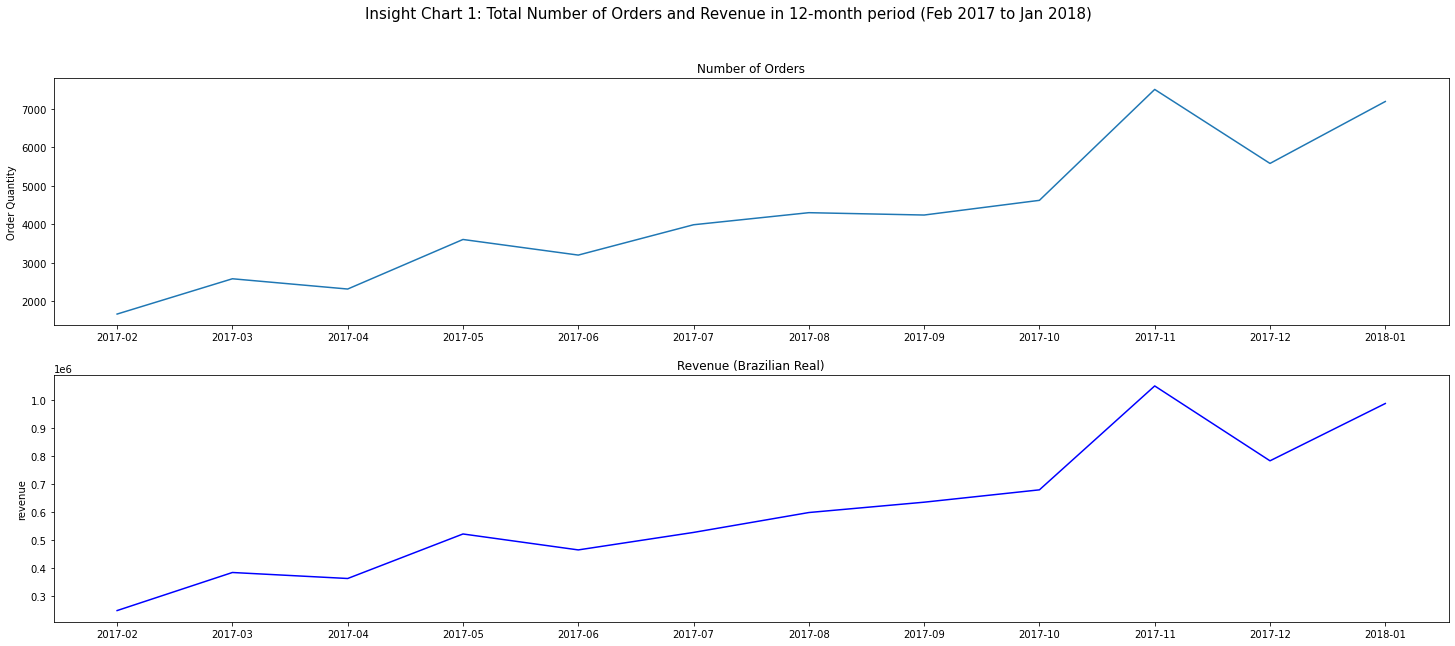

In [388]:
#Create datasets and plot information about Order Quantity and Revenue in the 12 months (2017-02 to 2018-01)
ord_period = df.groupby('year_month')['o_id'].count().reset_index()
ord_period = ord_period.rename(columns = {'o_id':'orders_count'})
ord_period = ord_period[ord_period['year_month'].isin(month_period)]

rev_period = df.groupby('year_month')['revenue'].sum().reset_index()
rev_period = rev_period[rev_period['year_month'].isin(month_period)]

plt.figure(figsize=(25,10))

plt.subplot(211)
sns.lineplot(data=ord_period, x='year_month', y='orders_count')
plt.xlabel('')
plt.ylabel('Order Quantity')
plt.title('Number of Orders')

plt.subplot(212)             
sns.lineplot(data=rev_period, x='year_month', y='revenue', color='blue')
plt.xlabel('')
plt.title('Revenue (Brazilian Real)')

plt.suptitle('Insight Chart 1: Total Number of Orders and Revenue in 12-month period (Feb 2017 to Jan 2018)',size=15)

plt.show()

The Peak time which is taken into analysis is from **November to January**, for example above **2017-11 to 2018-01**, as it can be seen from the charts that the Order Quantity and Revenue **reached two maximum levels** in two months of these three months.

In [98]:
#Divide the dataset of top 5 states into Peak and Non-peak datasets
df_top5 = df[df['c_state'].isin(top5)]
nonpeak = df[(df['year_month'].isin(['2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10'])) 
        & (df['c_state'].isin(top5))]
peak = df[(df['year_month'].isin(['2017-11','2017-12','2018-01']))& (df['c_state'].isin(top5))]

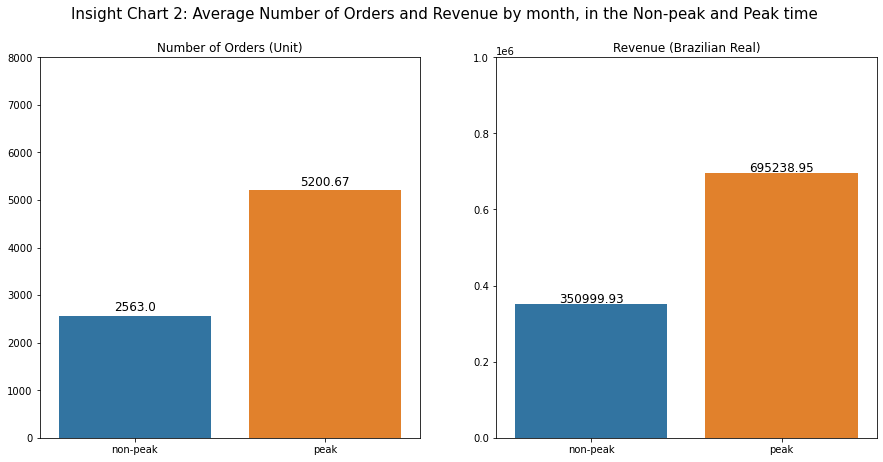

In [328]:
#Calculate average figures (Order Quantity and Revenue) by month in Non-peak and Peak time
nonpeak_order = nonpeak.groupby('year_month')['o_id'].count().reset_index()
peak_order = peak.groupby('year_month')['o_id'].count().reset_index()
nonpeak_peak_order = [nonpeak_order['o_id'].mean(),peak_order['o_id'].mean()]

nonpeak_rev = nonpeak.groupby('year_month')['revenue'].sum().reset_index()
peak_rev = peak.groupby('year_month')['revenue'].sum().reset_index()
nonpeak_peak_rev = [nonpeak_rev['revenue'].mean(),peak_rev['revenue'].mean()]

plt.figure(figsize=(14,6))
plt.subplot(121)
sns.barplot(x=['non-peak','peak'],y=nonpeak_peak_order)
for i in range (0,2):
    plt.text(
        x = i,
        y = int (nonpeak_peak_order[i]) +100,
        s = round(nonpeak_peak_order[i],2),
        ha = 'center',
        fontsize = 'large'
    )
plt.ylim(0,8000)
plt.title('Number of Orders (Unit)')

plt.subplot(122)
sns.barplot(x=['non-peak','peak'],y=nonpeak_peak_rev)
for i in range (0,2):
    plt.text(
        x = i,
        y = int (nonpeak_peak_rev[i]) +5000,
        s = round(nonpeak_peak_rev[i],2),
        ha = 'center',
        fontsize = 'large'
    )
plt.ylim(0,1000000)
plt.title('Revenue (Brazilian Real)')

plt.suptitle('Insight Chart 2: Average Number of Orders and Revenue by month, in the Non-peak and Peak time', size=15)
plt.savefig('NonPeakvsPeak.png')

- Average number of orders by a peak month: **+103%** more compared to a non-peak month
- Average revenue by a peak month: **+98%** more compare to a non-peak month

In [670]:
order_rev_peak = pd.DataFrame(data={'Period':['Non-peak','Peak'],
                                'Number of Orders':[nonpeak_order['o_id'].mean(),peak_order['o_id'].mean()],
                               'Revenue':[nonpeak_rev['revenue'].mean(),peak_rev['revenue'].mean()]})
order_rev_peak

,Period,Number of Orders,Revenue
0,Non-peak,2563.000000,350999.928889
1,Peak,5200.666667,695238.950000


In [671]:
#Export to CSV files

#12-month order quantity and revenue
ord_period.to_csv('ord_period.csv',index=False)
rev_period.to_csv('rev_period.csv',index=False)

#Comparison table between Non-peak and peak month
order_rev_peak.to_csv('order_rev_peak.csv')

#Peak and Non-peak datasets
nonpeak.to_csv('nonpeak.csv',index=False)
peak.to_csv('peak.csv',index=False)

## Overview of Late Delivery over the period

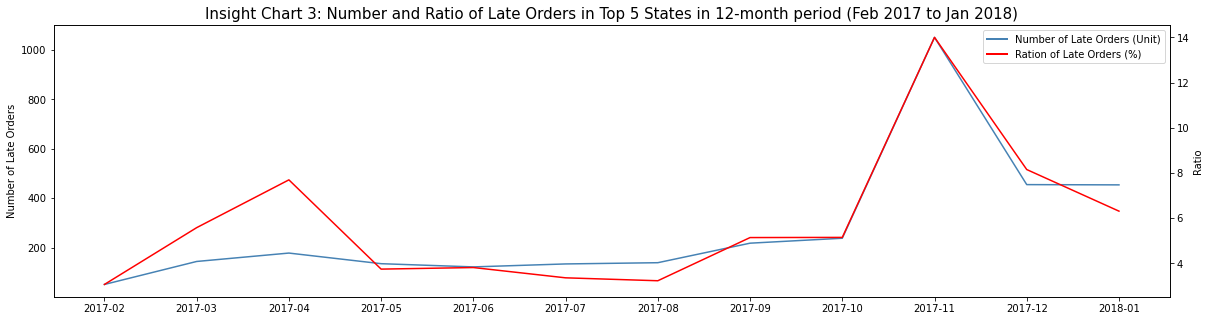

In [330]:
late_delivery = df[df['late_dlv']=='late'].groupby('year_month')['o_id'].count().reset_index()
late_delivery = pd.merge(late_delivery,ord_period,on='year_month')
late_delivery['late_ratio']=late_delivery['o_id']/late_delivery['orders_count']*100
plt.figure(figsize = (20,5))
sns.lineplot(data=late_delivery,x='year_month',y='o_id',color='steelblue')
plt.xlabel('')
plt.ylabel('Number of Late Orders')

plt.twinx()
sns.lineplot(data=late_delivery,x='year_month',y='late_ratio',color='red')
plt.ylabel('Ratio')

legend_elements = [
    plt.Line2D([0], [0], color='steelblue', lw=2, label='Number of Late Orders (Unit)'),
    plt.Line2D([0], [0], color='r', lw=2, label='Ration of Late Orders (%)')  
]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Insight Chart 3: Number and Ratio of Late Orders in Top 5 States in 12-month period (Feb 2017 to Jan 2018)',size=15) 
plt.show()

The number and ratio of late orders **increase in the Early Peak**, but tended to **decrease to the Last Peak**, although the number of orders increased in November and January.

For easy understanding: 
- November (2017-11) will be called the **Early-Peak** period
- December (2017-12) will be called the **Middle-Peak** period
- January (2018-01) will be called the **Last-Peak** period

In [276]:
def period(x):
    if x == '2017-11':
        return '1 - Early Peak'
    elif x == '2017-12':
        return '2 - Mid Peak'
    elif x== '2018-01':
        return '3 - Last Peak'

peak['period'] = peak['year_month'].apply(period)
peak

/tmp/ipykernel_123/1499940574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak['period'] = peak['year_month'].apply(period)


,o_id,p_id,s_state,c_state,main_category,revenue,late_dlv,year_month,est_dlv,act_dlv,dlv_pur,dlv_cr,same_state,period
20,403b97836b0c04a622354cf531062e5f,638bbb2a5e4f360b71f332ddfebfd672,SP,RJ,contructions & specific industries,1376.45,on_time,2018-01,34.0,17.0,17,16,not,3 - Last Peak
22,85ce859fd6dc634de8d2f1e290444043,cce679660c66e6fbd5c8091dfd29e9cd,SP,SP,home/living,29.75,on_time,2017-11,19.0,6.0,6,3,same,1 - Early Peak
39,989225ba6d0ebd5873335f7e01de2ae7,6b64362e89896be7589621df54be089e,PR,SP,home/living,63.10,on_time,2017-12,24.0,20.0,22,18,not,2 - Mid Peak
48,6ea2f835b4556291ffdc53fa0b3b95e8,be021417a6acb56b9b50d3fd2714baa8,SC,SP,home/living,356.12,late,2017-11,25.0,33.0,33,14,not,1 - Early Peak
61,641fb0752bf5b5940c376b3a8bb9dc52,60184212dae4e6b0da32bf54271a8c4a,SP,RJ,clothes/fashion,386.33,on_time,2017-12,31.0,19.0,19,15,not,2 - Mid Peak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,788541a19c0791de0504c5a9cb7e7bd5,27d0fc55e3d2fe698088f2603e0a2ab6,SP,PR,home/living,147.35,on_time,2017-11,26.0,13.0,13,7,not,1 - Early Peak
118412,6ec4642f9993cc34f826cfb9068e5a2f,9503faef00966962beacdb4916272305,SP,MG,contructions & specific industries,319.25,on_time,2017-11,16.0,10.0,10,4,not,1 - Early Peak
118417,0e4b26f1fb99fc0f0472dd5f403d36d4,e71f3cd0a0ef69b7fd173b32322dc6da,SP,SP,home/living,37.94,on_time,2017-11,11.0,2.0,2,0,same,1 - Early Peak
118420,cfa78b997e329a5295b4ee6972c02979,3d2c44374ee42b3003a470f3e937a2ea,SC,PR,books/stationery/media,71.04,late,2017-12,28.0,37.0,37,36,not,2 - Mid Peak


In [675]:
#Export to CSV files

#Late Delivery
late_delivery2 = late_delivery[late_delivery['year_month'].isin(['2017-11','2017-12','2018-01'])]
late_delivery2.to_csv('late_delivery.csv')

#New Peak time Dataset
peak.to_csv('peak.csv',index=False)

## Further analysis in Peak Time, by Category

### Number and % change of Order quantity

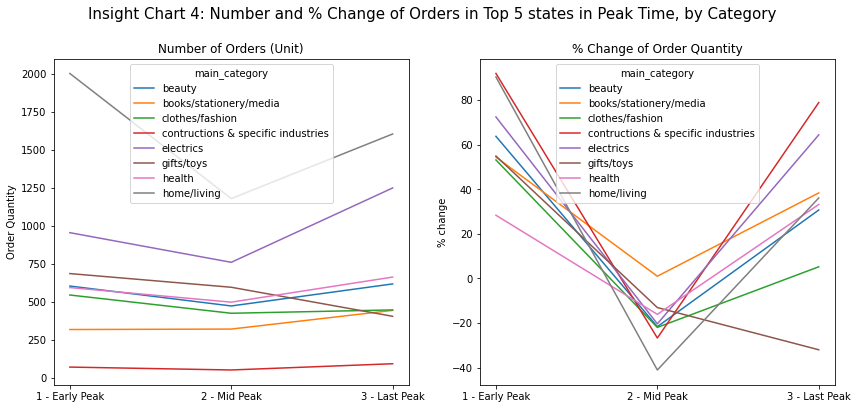

In [400]:
#Number of orders and % Change of Order Quantity, by Category

peak_category = peak.groupby(['year_month','main_category'])['o_id'].count().reset_index()
peak_category['period'] = peak_category['year_month'].apply(period)
peak_category = peak_category.rename(columns={'o_id':'order_count'})

peak_category_growth = df_top5.groupby(['year_month','main_category'])['o_id'].count().reset_index()
peak_category_growth = peak_category_growth[peak_category_growth['year_month'].isin(['2017-10','2017-11','2017-12','2018-01'])]
peak_category_growth['% change'] = peak_category_growth.groupby('main_category')['o_id'].pct_change()*100
peak_category_growth = peak_category_growth[peak_category_growth['year_month'].isin(['2017-11','2017-12','2018-01'])]
peak_category_growth['period'] = peak_category_growth['year_month'].apply(period)

plt.figure(figsize=(14,6))
plt.subplot(121)
sns.lineplot(data=peak_category,x='period',y='order_count',hue='main_category')
plt.xlabel('')
plt.ylabel('Order Quantity')
plt.title('Number of Orders (Unit)')

plt.subplot(122)
sns.lineplot(data=peak_category_growth,x='period',y='% change',hue='main_category')
plt.xlabel('')
plt.title('% Change of Order Quantity')   

plt.suptitle('Insight Chart 4: Number and % Change of Orders in Top 5 states in Peak Time, by Category', size=15, y=1)
plt.show()

- During the **Early peak** period, most products **increased steadily**, with the strongest growth in 3 main categories: **home/living, electrics, gifts/toys** (*constructions* increased sharply but its volume was not significant). Reasons might be due to the time of Black Friday/year-end sales, and many coming-up holidays (Thanksgiving, Christmas, New Year's Eve,...), so there would be a rising need for home/living, gifts/toys items.

- In the **Last peak**, **home/living** was still the category with the most orders, however **electrics** growed stronger. A hypothesis was that most people returned to work after a long holiday, so the work-personalized products were beneficial.

To facilitate the analysis of the Peak Time, 3 types of products with high order volume and high growth (**home/living, electrics, gifts/toys**) will be analyzed more deeply.

### Late delivery

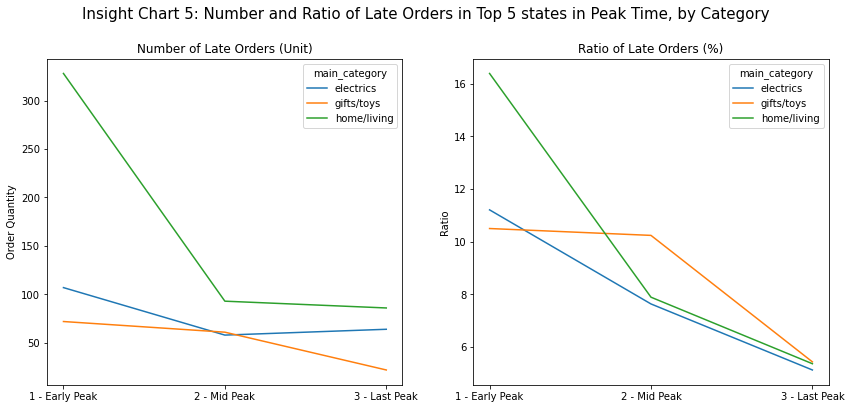

In [398]:
#Number and Ratio of Late orders, by Category

peak_ctg_late = peak[peak['late_dlv']=='late'].groupby(['year_month','main_category'])['o_id'].count().reset_index()
peak_ctg_late = peak_ctg_late.rename(columns={'o_id':'late'})
peak_ctg_late = pd.merge(peak_ctg_late,peak_category,on=['year_month','main_category'])
peak_ctg_late['ratio'] =  peak_ctg_late['late']/peak_ctg_late['order_count']*100
peak_ctg_late = peak_ctg_late[peak_ctg_late['main_category'].isin(['home/living','electrics','gifts/toys'])]
peak_ctg_late['period'] = peak_ctg_late['year_month'].apply(period)

plt.figure(figsize=(14,6))
plt.subplot(121)
sns.lineplot(data=peak_ctg_late,x='period',y='late',hue='main_category')
plt.xlabel('')
plt.ylabel('Order Quantity')
plt.title('Number of Late Orders (Unit)')

plt.subplot(122)
sns.lineplot(data=peak_ctg_late,x='period',y='ratio',hue='main_category')
plt.xlabel('')
plt.ylabel('Ratio')
plt.title('Ratio of Late Orders (%)')

plt.suptitle('Insight Chart 5: Number and Ratio of Late Orders in Top 5 states in Peak Time, by Category',size=15,y=1)

plt.show()

- At **Early peak**, the rate of late orders of all 3 categories increased, with the highest ratio of more than 16% (**home/living**). The remaining 2 types are over 10%.
- From **Mid to Last-peak**, the ratio of late orders **decreased**. 
- However, at mid-peak, the rate of late orders for **gifts/toys remained above 10%**. The reason was that the demand for this type of product was still maintained at a high level due to **the long year-end holidays**.

**Potential Solutions**, based on Category:
- **Increase the amount of Home/Living, and Electrics products in stock** to reduce approval time and send items to carriers.
- In Early-Mid Peak, **prioritize processing & delivering items** that achieve strong growth in its period such as **Gifts/Toys**.

In [688]:
#Export to CSV Files
peak_category_growth.to_csv('peak_category_growth.csv',index=False)
peak_ctg_late.to_csv('peak_ctg_late.csv',index=False)

## Further analysis in Peak-time, by Location

### Analysis on number and % change of Order quantity

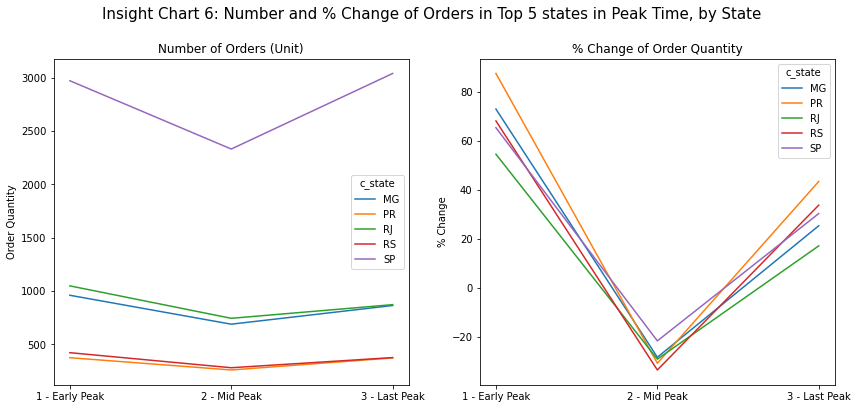

In [396]:
#Number of orders and % Change of Order Quantity, by State

peak_state = peak.groupby(['c_state','year_month'])['o_id'].count().reset_index().sort_values('year_month')
peak_growth = df_top5.groupby(['c_state','year_month'])['o_id'].count().reset_index().sort_values(['year_month','c_state'])
peak_growth = peak_growth[peak_growth['year_month'].isin(['2017-10','2017-11','2017-12','2018-01'])]
peak_growth['% Change'] = peak_growth.groupby('c_state')['o_id'].pct_change()*100
peak_state = pd.merge(peak_state,peak_growth,how='left',on=['c_state','year_month','o_id'])
peak_state = peak_state.rename(columns = {'o_id':'order_count'})
peak_state['period'] = peak_state['year_month'].apply(period)
peak_state

plt.figure(figsize=(14,6))

plt.subplot(121)
sns.lineplot(data=peak_state,x='period',y='order_count',hue='c_state')
plt.xlabel('')
plt.ylabel('Order Quantity')
plt.title('Number of Orders (Unit)')

plt.subplot(122)
sns.lineplot(data=peak_state,x='period',y='% Change',hue='c_state')
plt.xlabel('')
plt.title('% Change of Order Quantity')

plt.suptitle('Insight Chart 6: Number and % Change of Orders in Top 5 states in Peak Time, by State',size=15,y=1)

plt.show()

- **SP was the outstanding state** in the top 5. RJ and MG were in the middle group. RS and PR were in the lower group.
- However, in terms of **% change of Order Quantity**: **PR** was the state with **the highest order quantity growth rate** (early peak more than 80%, last peak more than 40%).
- Every state experienced a **relatively similar pattern** in % change, with a rate between 50-90% at the Early Peak and 10-50% at the Last Peak.

### Late Delivery

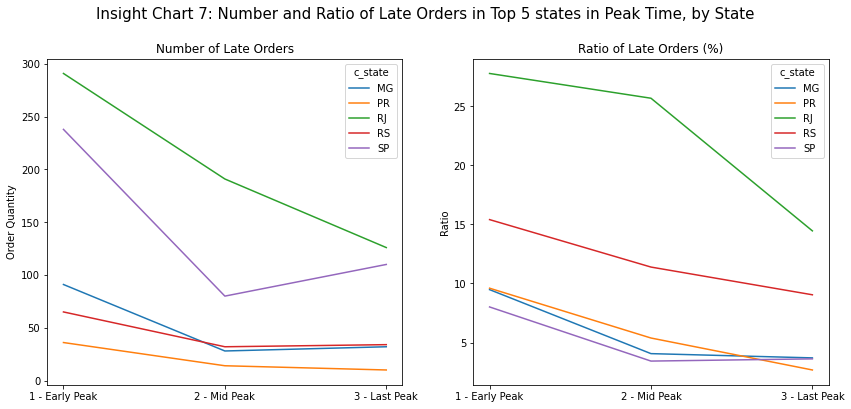

In [394]:
#Number and Ratio of Late orders, by State

peak_state_delivery = peak[peak['late_dlv']=='late'].groupby(['year_month','c_state'])['o_id'].count().reset_index()
peak_state_delivery = peak_state_delivery.rename(columns={'o_id':'late_orders'})
peak_state_delivery = pd.merge(peak_state_delivery,peak_state,on=['year_month','c_state'])
peak_state_delivery['ratio']=peak_state_delivery['late_orders']/peak_state_delivery['order_count']*100
peak_state_delivery.sort_values('c_state',inplace=True)


plt.figure(figsize = (14,6))
plt.subplot(121)
sns.lineplot(data=peak_state_delivery,x='period',y='late_orders',hue='c_state')
plt.xlabel('')
plt.ylabel('Order Quantity')
plt.title('Number of Late Orders')

plt.subplot(122)
sns.lineplot(data=peak_state_delivery,x='period',y='ratio',hue='c_state')
plt.xlabel('')
plt.ylabel('Ratio')
plt.title('Ratio of Late Orders (%)')

plt.suptitle('Insight Chart 7: Number and Ratio of Late Orders in Top 5 states in Peak Time, by State', size=15,y=1)
plt.show()

- Despite not being outstanding in the number of orders, the number and ratio of **RJ and RS** were the **highest** among the Top 5 States.
- The ratio of late orders tended to **decrease over the period**.

In [700]:
#Export to CSV Files
peak_state.to_csv('peak_state.csv',index=False)
peak_state_delivery.to_csv('peak_state_delivery.csv',index=False)

### Late Delivery in SP

SP was the crucial state, which was responsible for much of Olist's performance during the Peak Time period.
In more detail, in 2017 Peak Time: 
- Number of Orders: SP accounted for **53.44 % total number of orders** in Top 5 States.
- Revenue: SP accounted for **50.0 % total revenue** in Top 5 States.

In [297]:
round (peak[peak['c_state']=='SP']['o_id'].count()/peak['o_id'].count()*100,2)

53.44

In [299]:
round(peak[peak['c_state']=='SP']['revenue'].sum()/peak['revenue'].sum()*100,2)

50.0

As illustrated in the *Insight Chart 7*, In the **Last Peak**, SP's **ratio of late deliveries** was **still maintained**, although the number of total orders rose substantially (while other states had their late ratio decreased), 

The **number of late orders** in SP in the Last Peak **increased**, which is **a reverse sign** compared to the pattern of the remaining 4 states. However, as its ratio of late orders didn't make any substantial rise, the **late delivery issues in SP** in the Last Peak could be considered **tolerable** and **not a worrisome pattern**.

### Late Delivery in RS

As illustrated in the *Insight Chart 7*, despite not relatively high in the Top 5 states in terms of the orders’ amount, **RS's ratio of late-delivery** was **the second-highest**, which was considerably higher than states with higher order quantity (SP, MG).

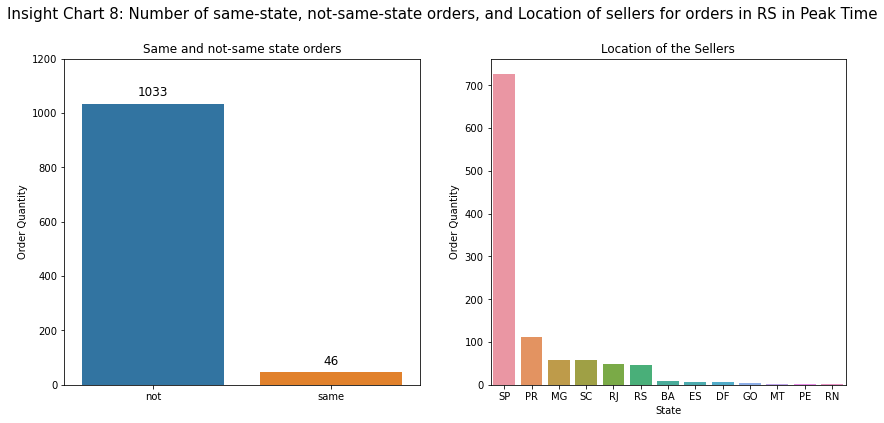

In [412]:
#Analyzing the source(sellers) of orders in RS

rs_same_state = peak[peak['c_state']=='RS']['same_state'].value_counts().reset_index()
rs_same_state.columns =  ['State','Order Quantity']

rs_seller = peak[peak['c_state']=='RS']['s_state'].value_counts().reset_index()
rs_seller.columns = ['State','Order Quantity']

plt.figure(figsize = (14,6))
plt.subplot(121)
sns.barplot(data=rs_same_state, x='State', y='Order Quantity')
plt.xlabel('')
for i in range (0,2):
    plt.text(
        x = i,
        y = int (rs_same_state['Order Quantity'][i]) +30,
        s = rs_same_state['Order Quantity'][i],
        ha = 'center',
        fontsize = 'large'
    )
plt.ylim(0,1200)
plt.title('Same and not-same state orders')

plt.subplot(122)
sns.barplot(data=rs_seller, x='State', y='Order Quantity')
plt.title('Location of the Sellers')

plt.suptitle('Insight Chart 8: Number of same-state, not-same-state orders, and Location of sellers for orders in RS in Peak Time',size=15,y=1)      
plt.show()

Upon conducting a thorough analysis of the nature and origin of orders in RS in Peak Time, we can see

- The majority of orders made in RS had sellers who were in **different states** (96% orders were not-same state).
- Sellers of the orders shipped to RS were **mainly from SP** (accounted for 67% order quantity).

Therefore, in some respects, the high ratio of late orders in RS could be explained by **the large distance between SP and RS**.

<img src="https://i.imgur.com/wBvdafX.png" width="300">

In [707]:
#Export to CSV Files
rs_same_state.to_csv('rs_same_state.csv',index=False)
rs_seller.to_csv('rs_seller.csv',index=False)

### Late Delivery in RJ

As illustrated in the *Insight Chart 6*, **RJ** was the **second-highest order quantity** in the Top 5 states.
However, in the **Last Peak**, the **number** and **ratio of late orders** in **RJ** was **the highest** among Top 5 states, as illustrated in the *Insight Chart 7*.

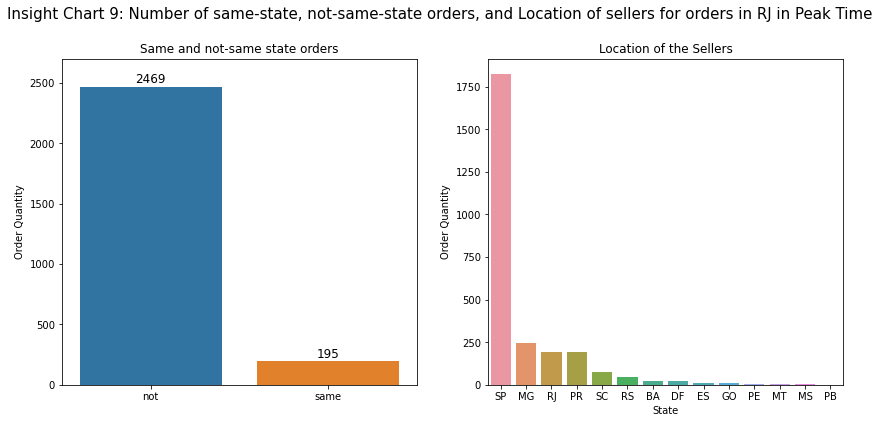

In [108]:
#Analyzing the source(sellers) of orders in RJ

rj_same_state = peak[peak['c_state']=='RJ']['same_state'].value_counts().reset_index()
rj_same_state.columns =  ['State','Order Quantity']

rj_seller = peak[peak['c_state']=='RJ']['s_state'].value_counts().reset_index()
rj_seller.columns = ['State','Order Quantity']

plt.figure(figsize = (14,6))
plt.subplot(121)
sns.barplot(data=rj_same_state, x='State', y='Order Quantity')
plt.xlabel('')
for i in range (0,2):
    plt.text(
        x = i,
        y = int (rj_same_state['Order Quantity'][i]) +30,
        s = rj_same_state['Order Quantity'][i],
        ha = 'center',
        fontsize = 'large'
    )
plt.ylim(0,2700)
plt.title('Same and not-same state orders')

plt.subplot(122)
sns.barplot(data=rj_seller, x='State', y='Order Quantity')
plt.title('Location of the Sellers')

plt.suptitle('Insight Chart 9: Number of same-state, not-same-state orders, and Location of sellers for orders in RJ in Peak Time',size=15,y=1)      
plt.show()

- Orders from **RJ** followed a similar pattern to RS (**outstanding not-same-state orders** and **sellers mainly from SP**).
- However, **these two states are contiguous**, which is different from RS's pattern and a strange insight which should be taken into deeper researches.

<img src="https://i.imgur.com/g90rPVd.png" width="300">

The available datasets on Olist are insufficient to determine the causes of the high percentage of late deliveries in RJ. However, when RJ orders mainly depended on sellers in SP, one of the main potential reasons for the high ratio of late deliveries in RJ was **the poor quality of highways and logistics routes from SP to RJ**. Below are some data on transportation through Brazil's highways, as well as their quality, published in the article *Privatization: São Paulo's Proven Solution for Brazil's Long-suffering Highway System, Brazil Builds*:
- **90%** of Brazil's ton-mile freight is transported nationwide via its h**ighways and backroads**.
- **BR-116, BR-101** are two main routes, which were recorded for **more than 24% of all automobile accident fatalities** in **2017**.
- Just **25%** of the federal highways were **in good working order**, and approximately **65% of Brazil's public roads** were deemed to be in **poor condition** (recorded in **2017**).
- Many of Brazil's public roadways had deteriorated due to *inadequate paving, inadequate signaling, low maintenance, and excessive use*. These roads are also frequently underfunded annually and unfit for the everyday deterioration that millions of cars, trucks, and buses inflict. While **the number of automobiles** on Brazil's roadways has **expanded by 82.4%** over the past ten years, **paving efforts** have increased by just **8.4%**.


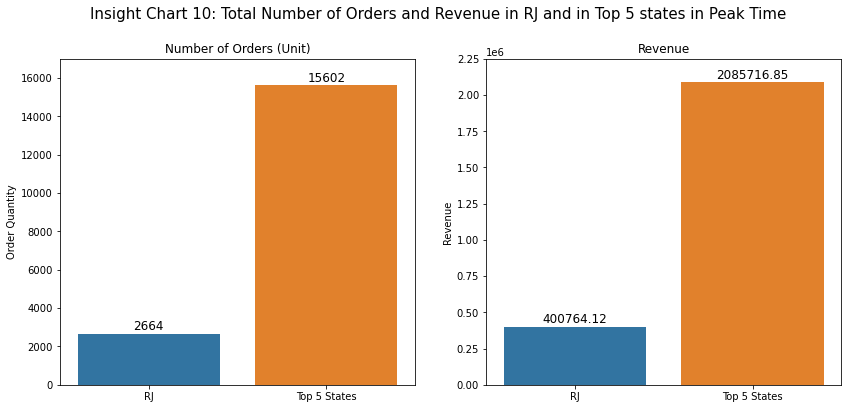

In [161]:
#Proportion of RJ in the Top 5 States, in terms of Number of Orders and Revenue
rj_order_revenue = pd.DataFrame(data={'Number of Order':['RJ','Top 5 States'],
                                'Orders':[peak[peak['c_state']=='RJ'].shape[0],peak.shape[0]],
                               'Revenue':[peak[peak['c_state']=='RJ']['revenue'].sum(),peak['revenue'].sum()]})
rj_order_revenue.columns = ['State','Order Quantity','Revenue']
rj_order_revenue

plt.figure(figsize = (14,6))
plt.subplot(121)
sns.barplot(data=rj_order_revenue, x='State', y='Order Quantity')
plt.xlabel('')
for i in range (0,2):
    plt.text(
        x = i,
        y = int (rj_order_revenue['Order Quantity'][i]) +200,
        s = rj_order_revenue['Order Quantity'][i],
        ha = 'center',
        fontsize = 'large'
    )
plt.ylim(0,17000)
plt.title('Number of Orders (Unit)')

plt.subplot(122)
sns.barplot(data=rj_order_revenue, x='State', y='Revenue')
plt.xlabel('')
for i in range (0,2):
    plt.text(
        x = i,
        y = int (rj_order_revenue['Revenue'][i]) +30000,
        s = round(rj_order_revenue['Revenue'][i],2),
        ha = 'center',
        fontsize = 'large'
    )
plt.ylim(0,2250000)
plt.title('Revenue')

plt.suptitle('Insight Chart 10: Total Number of Orders and Revenue in RJ and in Top 5 states in Peak Time',size=15,y=1)      
plt.show()

Indicators show that RJ state's order quantity accounted for **17% of total order**, with revenue accounting for nearly **20% of the total revenue** of the 5 states during the Peak period (beside SP with 53% and 50% respectively).

**-> Solutions should be made**, if Olist plans to widen the business outside SP.

#### Late Delivery in RJ, by Category

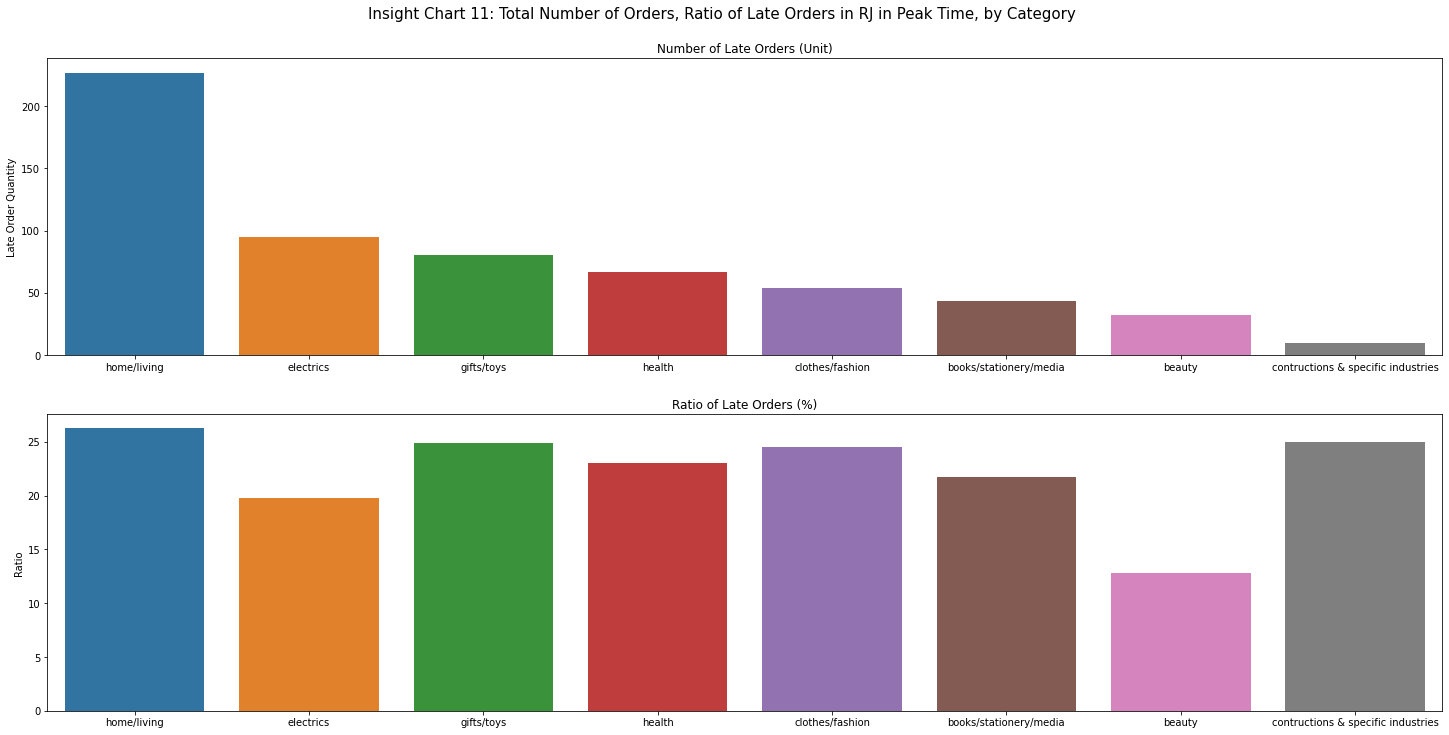

In [262]:
#Analyzing RJ Late Delivery, by Category

rj_ctg = peak[peak['c_state']=='RJ']['main_category'].value_counts().reset_index()
rj_ctg_late = peak[(peak['c_state']=='RJ')&(peak['late_dlv']=='late')]['main_category'].value_counts().reset_index()
rj_ctg = pd.merge(rj_ctg,rj_ctg_late,on='index')
rj_ctg.columns = ['Main Category','Total','Late']
rj_ctg['Ratio'] =  rj_ctg['Late']/rj_ctg['Total']*100
rj_ctg.columns = ['Main Category','Total Orders','Late Order Quantity','Ratio']
rj_ctg = rj_ctg.sort_values('Late Order Quantity',ascending = False)

plt.figure(figsize = (25,12))

plt.subplot(211)
sns.barplot(data=rj_ctg, x='Main Category',y='Late Order Quantity')
plt.xlabel('')
plt.title('Number of Late Orders (Unit)')


plt.subplot(212)
sns.barplot(data=rj_ctg, x='Main Category',y='Ratio')
plt.xlabel('')
plt.title('Ratio of Late Orders (%)')

plt.suptitle('Insight Chart 11: Total Number of Orders, Ratio of Late Orders in RJ in Peak Time, by Category',size=15, y=0.94)

plt.show()

- The top 3 main categories with highest number of orders in RJ: **home/living, electrics, gifts/toys**.
- Of those 3 main categories, **home/living** and **gifts/toys** were among the **highest late ratios**.

**Potential Solutions**: 

- **Improve ETD Forecast** (*Estimated Time of Departure Forecast*): optimize transport routes and delivery time from SP to RJ.
- **Supply Augmentation**: Consider **increasing imported supply**, leverage **RJ’s proximity to the sea**.
- **Stock up** on more **Home/Living** and **Electrics** products to **expedite approval and dispatch to carriers process**.
- In Early-Mid Peak, **prioritize processing items** experiencing strong growth during a certain period such as **Gifts/Toys**.

#### Delivery days in RJ, by Category

In this part, **the difference between estimate and actual delivery days** are focused, which is calculated as below:  
- **Actual Delivery Days** (*of an order*) = `act_delivery_date` - `purchase`
- **Estimated Delivery Days** (*of an order*) = `act_delivery_date` - `purchase`
- **Difference** = Avg. Estimated Delivery Days - Avg. Actual Delivery Days 
                         *(Both are calculated on average, grouped by Year-Month, Category)*
If **Difference** >= 0, delivery is **on time**.
If **Difference** < 0, delivery is **late**.

In [291]:
#Create a dataset to calculate Difference in RJ in Peak Time, by Year-Month and Category

peak_est_ctg = peak[peak['c_state']=='RJ'].groupby(['year_month','main_category'])['est_dlv'].mean().reset_index()
peak_act_ctg = peak[peak['c_state']=='RJ'].groupby(['year_month','main_category'])['act_dlv'].mean().reset_index()
peak_est_act_ctg = pd.merge(peak_est_ctg,peak_act_ctg,on=['year_month','main_category'])
peak_est_act_ctg['dif'] =  peak_est_act_ctg['est_dlv']-peak_est_act_ctg['act_dlv']
peak_est_act_ctg = peak_est_act_ctg[peak_est_act_ctg['main_category'].isin(['home/living','electrics','gifts/toys'])]
peak_est_act_ctg.rename (columns = {'dif':'Difference Days'},inplace=True)
peak_est_act_ctg = peak_est_act_ctg.reset_index().drop(columns='index')
peak_est_act_ctg

,year_month,main_category,est_dlv,act_dlv,Difference Days
0,2017-11,electrics,21.668831,16.623377,5.045455
1,2017-11,gifts/toys,19.522059,15.705882,3.816176
2,2017-11,home/living,21.882927,21.007317,0.875610
3,2017-12,electrics,27.500000,20.641667,6.858333
4,2017-12,gifts/toys,26.000000,21.887931,4.112069
5,2017-12,home/living,28.600985,21.763547,6.837438
6,2018-01,electrics,27.169903,16.538835,10.631068
7,2018-01,gifts/toys,27.304348,19.028986,8.275362
8,2018-01,home/living,28.384921,18.789683,9.595238


Text(0.5, 1.0, 'Insight Chart 12: Difference between Estimated and Actual Delivery Days for orders in RJ in Peak Time, by Category')

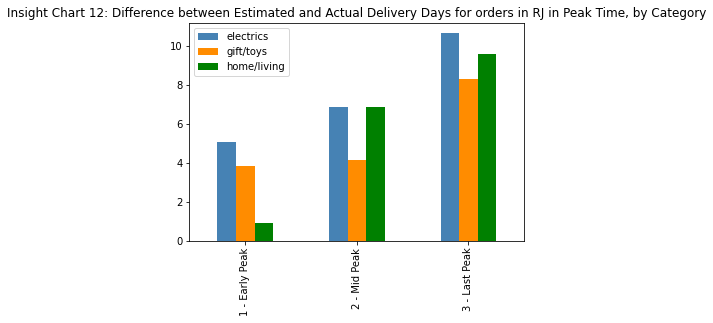

In [311]:
#Plot Difference Data
dif1 = [peak_est_act_ctg['Difference Days'][0],peak_est_act_ctg['Difference Days'][1],peak_est_act_ctg['Difference Days'][2]]
dif2 = [peak_est_act_ctg['Difference Days'][3],peak_est_act_ctg['Difference Days'][4],peak_est_act_ctg['Difference Days'][5]]
dif3 = [peak_est_act_ctg['Difference Days'][6],peak_est_act_ctg['Difference Days'][7],peak_est_act_ctg['Difference Days'][8]]

groups = [dif1, dif2, dif3]
group_labels = ['1 - Early Peak', '2 - Mid Peak', '3 - Last Peak']

# Convert data to pandas DataFrame.
draft = pd.DataFrame(groups, index=group_labels).T

# Plot.
pd.concat(
    [
        draft.iloc[0].rename('electrics'), 
        draft.iloc[1].rename('gift/toys'), 
        draft.iloc[2].rename('home/living')
    ],
    axis=1,
).plot.bar(color=['steelblue','darkorange','green']
          ).set_title('Insight Chart 12: Difference between Estimated and Actual Delivery Days for orders in RJ in Peak Time, by Category')


It can be seen that the **Difference in Home/Living products** in the **Early Peak** was only **1 day**, which means **many late and close-to-time orders**, caused by **problems in the delivery estimating system**.

**Potential Solutions**:

- **Modify the estimated date/estimated system** and **inform consumers clearly and concisely** about the delivery time and order processing procedure.
- Consider **delivery times in different hours** in a day.

In [ ]:
#Export to CSV Files
rj_same_state.to_csv('rj_same_state.csv',index=False)
rj_seller.to_csv('rj_seller.csv',index=False)
rj_order_revenue.to_csv('rj_order_revenue.csv',index=False)
rj_ctg.to_csv('rj_ctg.csv',index=False)
peak_est_act_ctg.to_csv('peak_est_act_ctg.csv')

# Conclusion of the analysis

This project focuses on analyzing **Olist** e-commerce activities in **2017 Peak Time** (November - January) in the **Top 5 states** with the highest numbers of orders (SP, RJ, MG, RS, PR).
- **By Category**: Over the Peak Time, **home/living** and **electrics** were the categories with the highest demands. **Gifts/toys** items were popular for ordering at Early and Mid Peak, due to **a number of holidays** lasting during the last two months of the year (Thanksgiving, Christmas, New Year Eve).
- **By Location**: **SP was the crucial state** in ensuring the performance of Olist during Peak Time (53% of Order quantity and 50% of total revenue of Top 5 State during Peak Time). However, **RJ** had the **most concerning Late Delivery issue**, despite its geographical proximity to SP, which was its main supply source.
- One of the main reason for high ratio of late delivery in RJ in the **poor quality of highways and backroads** there. **BR-116, BR-101** are two main routes, which were recorded for **more than 24% of all automobile accident fatalities** in **2017**. Besides, just **25%** of the federal highways were **in good working order**, and approximately **65% of Brazil's public roads** were deemed to be in **poor condition** (recorded in **2017**).
- RJ's issues should be focused to reduce the over-dependence on SP, such as **improving ETD Forecast** and **supply augmentation**. Solutions can go deep into categories, by **stocking up more popular products** during Peak Time. In terms of Delivery Days, a worrying insight was that the **Difference** between Estimate and Actual Delivery Days of home/living products was closely **small**, implying for **problems in the delivery estimating system**, which could be partly solved by **modifying the estimated system, concisely informing to customers and delivering in different hours in a day**.

# Final Words

Thank you for taking the time to read the above project. Please kindly click the following link to view my presentation slide with a Tableau visualization:
https://drive.google.com/file/d/14ntSJsxE3F2aJbcrWyPLERoG9EfCcCvG/view?usp=sharing 
